In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2, 2))

In [4]:
print(conv1)

print(conv1.weight.shape)
print(conv1.bias.shape)

print()
print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])

torch.Size([32, 32, 3, 3])
torch.Size([32])


In [6]:
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [7]:
x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [9]:
print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


In [10]:
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [11]:
outputs = features(inputs)
print(outputs.shape)

torch.Size([100, 32, 14, 14])


In [12]:
flatten = nn.Flatten()
outputs2 = flatten(outputs)

print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


In [13]:
def eval_loss(loader, device, net, criterion):
    for images, labels in loader:
        break

    inputs = images.to(device)
    outputs = labels.to(device)

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    return loss

In [14]:
# 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdm 라이브러리 임포트
    from tqdm.notebook import tqdm

    base_epochs = len(history) # => 0
    batch_size_train = len(train_loader)
    batch_size_test = len(test_loader)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 훈련 페이즈
        net.train() # dropout, batch normalization 활성화
        # count = 0

        for inputs, labels in tqdm(train_loader):
            # count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 경사 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 경사 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            train_acc += (predicted == labels).sum().item() /len(labels)

            # 손실과 정확도 계산
        avg_train_loss = train_loss / batch_size_train
        avg_train_acc = train_acc / batch_size_train

        # 예측 페이즈
        net.eval()
        # count = 0

        for inputs, labels in test_loader:
            # count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            val_acc += (predicted == labels).sum().item() /len(labels)

            # 손실과 정확도 계산
        avg_val_loss = val_loss / batch_size_test
        avg_val_acc = val_acc / batch_size_test

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [31]:
# 학습 로그 해석

def evaluate_history(history):
    # 손실과 정확도 확인
    print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}')
    print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 학습 곡선 출력(손실)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='train')
    plt.plot(history[:,0], history[:,3], 'k', label='valid')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('learning curve(loss)')
    plt.legend()
    plt.show()

    # 학습 곡선 출력(정확도)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='train')
    plt.plot(history[:,0], history[:,4], 'k', label='valid')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('learning curve(accuracy)')
    plt.legend()
    plt.show()

In [16]:
# 이미지와 라벨 표시
def show_images_labels(loader, classes, net, device):

    # 데이터로더에서 처음 1세트를 가져오기
    for images, labels in loader:
        break
    # 표시 수는 50개
    n_size = min(len(images), 50)
    print("n_size = ", n_size)

    if net is not None:
      # 디바이스 할당
      inputs = images.to(device)
      labels = labels.to(device)

      # 예측 계산
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 처음 n_size개 표시
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # net이 None이 아닌 경우는 예측 결과도 타이틀에 표시함
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 정답인지 아닌지 색으로 구분함
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # net이 None인 경우는 정답 라벨만 표시
        else:
          ax.set_title(label_name, fontsize=20)
        # 텐서를 넘파이로 변환
        image_np = images[i].numpy().copy()
        # 축의 순서 변경 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 값의 범위를[-1, 1] -> [0, 1]로 되돌림
        img = (img + 1)/2
        # 결과 표시
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


In [17]:
# 파이토치 난수 고정

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True #
    torch.use_deterministic_algorithms = True

In [19]:
from torchvision import datasets, transforms

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [20]:
data_root = './data'

train_set1 = datasets.CIFAR10(root = data_root, train=True, download=True, transform=transform1)
test_set1 = datasets.CIFAR10(root = data_root, train=False, download=True, transform=transform1)

train_set2 = datasets.CIFAR10(root = data_root, train=True, download=True, transform=transform2)
test_set2 = datasets.CIFAR10(root = data_root, train=False, download=True, transform=transform2)

100%|██████████| 170498071/170498071 [00:19<00:00, 8638995.63it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [21]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [22]:
from torch.utils.data import DataLoader

In [23]:
batch_size = 100

train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_set1, batch_size=batch_size, shuffle=False)

train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_set2, batch_size=batch_size, shuffle=False)

In [24]:
for images1, labels1 in train_loader1:
    break

for images2, labels2 in train_loader2:
    break

print(images1.shape)
print(images2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


n_size =  50


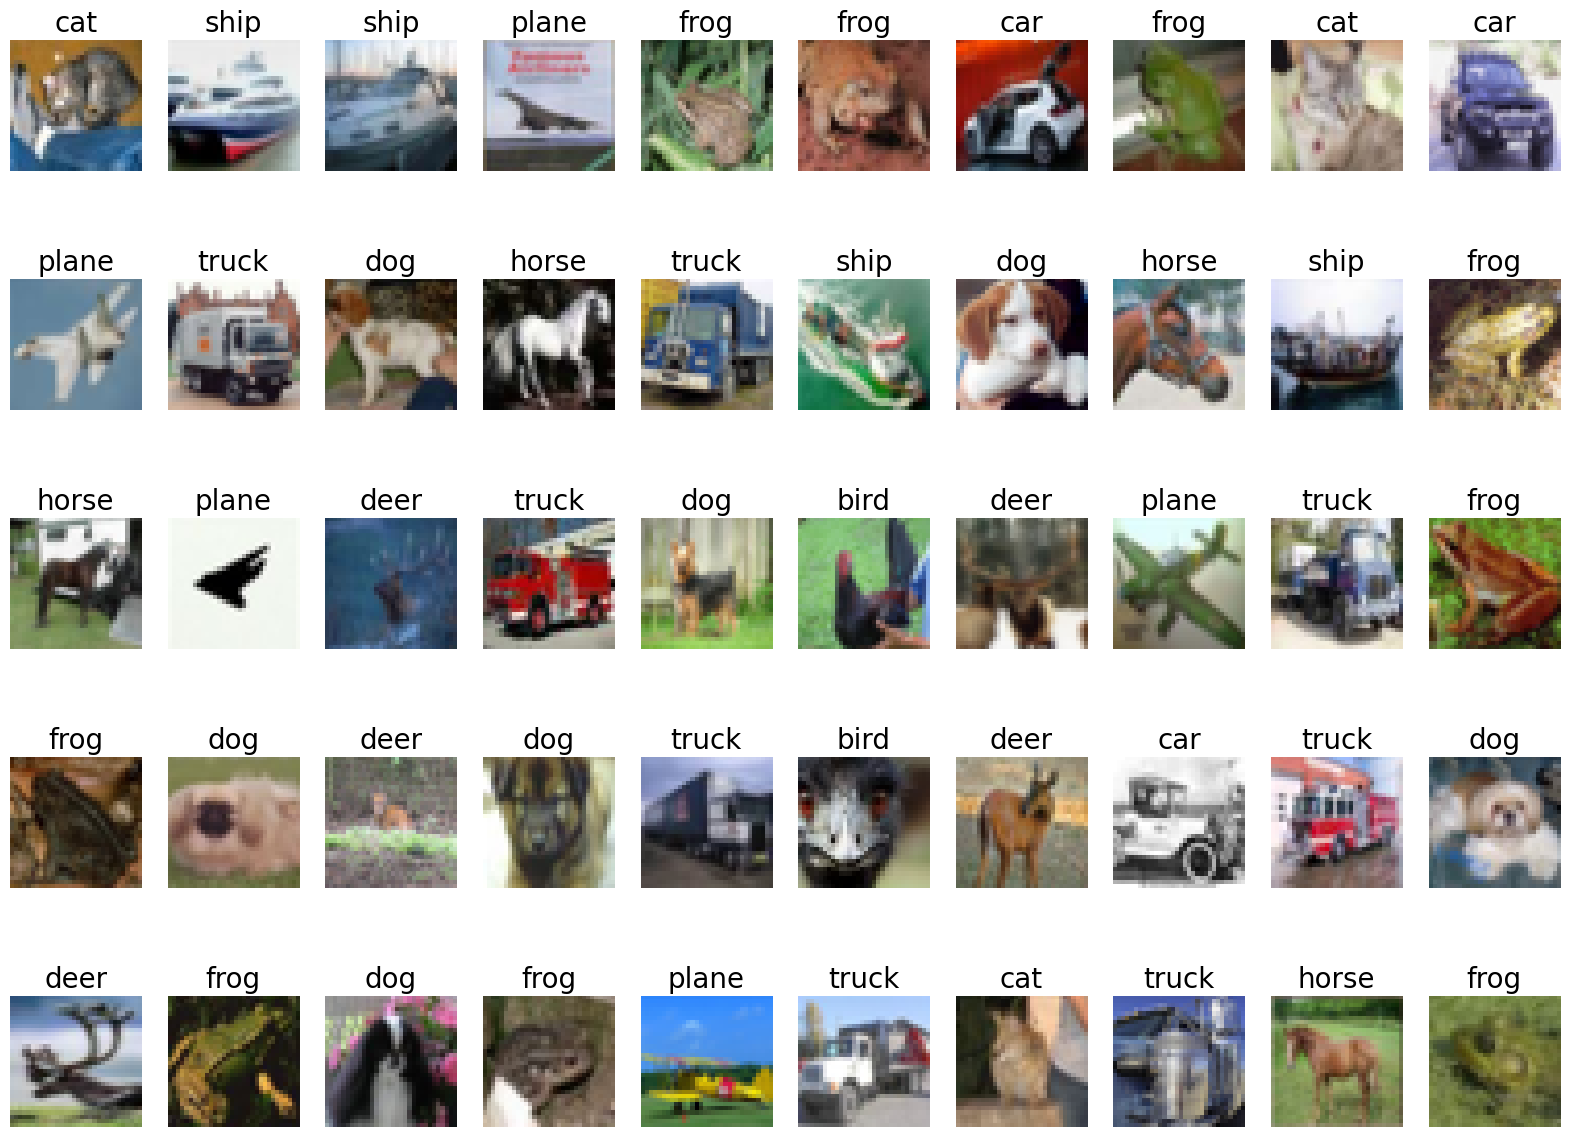

In [25]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
show_images_labels(test_loader2, classes, None, None)

In [26]:
n_input = image1.view(-1).shape[0]

n_output = len(set(list(labels1.data.numpy())))

n_hidden = 128

print(f'n_input: {n_input} n_hidden: {n_hidden} n_output {n_output}')

n_input: 3072 n_hidden: 128 n_output 10


In [27]:
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
torch_seed()
net = Net(n_input, n_output, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr)
num_epochs = 10
history = np.zeros((0, 5))
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/10], loss: 1.94965 acc: 0.32214 val_loss: 1.79426, val_acc: 0.37720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/10], loss: 1.73836 acc: 0.39578 val_loss: 1.68423, val_acc: 0.41780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/10], loss: 1.65494 acc: 0.42406 val_loss: 1.62214, val_acc: 0.43830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/10], loss: 1.60227 acc: 0.44270 val_loss: 1.58251, val_acc: 0.45140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/10], loss: 1.56316 acc: 0.45516 val_loss: 1.55313, val_acc: 0.46180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/10], loss: 1.53235 acc: 0.46798 val_loss: 1.52969, val_acc: 0.46870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/10], loss: 1.50487 acc: 0.47698 val_loss: 1.51214, val_acc: 0.47420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/10], loss: 1.48010 acc: 0.48648 val_loss: 1.49291, val_acc: 0.47790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/10], loss: 1.45691 acc: 0.49584 val_loss: 1.47967, val_acc: 0.48650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/10], loss: 1.43485 acc: 0.50492 val_loss: 1.46334, val_acc: 0.48930


초기상태 : 손실 : 1.79426  정확도 : 0.37720
최종상태 : 손실 : 1.46334  정확도 : 0.48930


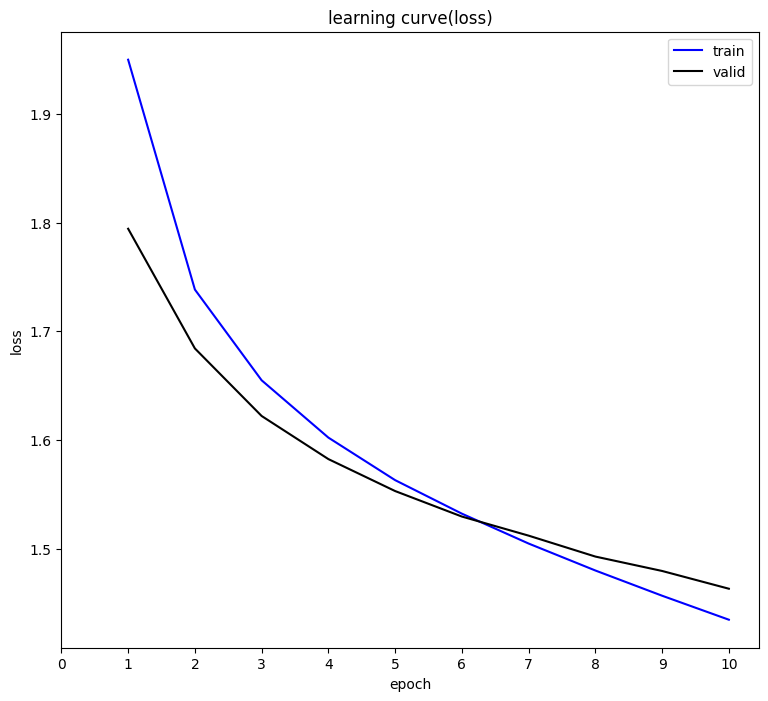

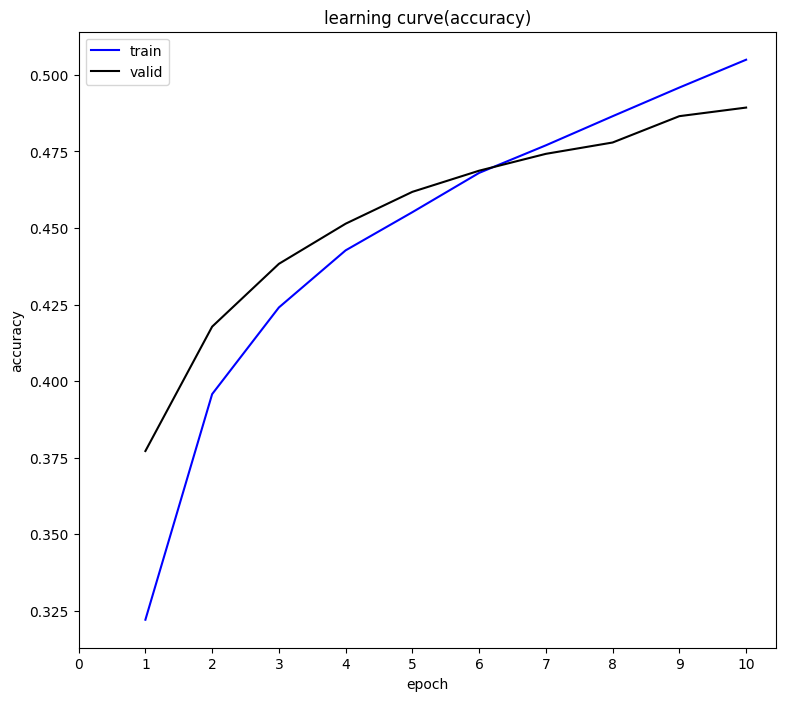

In [32]:
evaluate_history(history)

In [33]:
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(6272, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [35]:
# 모델 인스턴스 생성
net = CNN(n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [36]:
print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [37]:
from torchinfo import summary

summary(net, (100, 3, 32, 32), depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Flatten: 1-6                           [100, 6272]               --
├─Sequential: 1-7                        [100, 10]                 804,234
Total params: 823,626
Trainable params: 823,626
Non-trainable params: 0
Total mult-adds (M): 886.11
Input size (MB): 1.23
Forward/backward pass size (MB): 43.22
Params size (MB): 3.26
Estimated Total Size (MB): 47.71

In [39]:
torch_seed()
net = CNN( n_output, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr)
num_epochs = 20
history2 = np.zeros((0, 5))
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 2.08250 acc: 0.26116 val_loss: 1.86587, val_acc: 0.34720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 1.78085 acc: 0.37328 val_loss: 1.67682, val_acc: 0.41030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 1.61308 acc: 0.43108 val_loss: 1.53040, val_acc: 0.45970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 1.48507 acc: 0.47294 val_loss: 1.44887, val_acc: 0.48830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 1.40747 acc: 0.49962 val_loss: 1.36882, val_acc: 0.51300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 1.34919 acc: 0.52122 val_loss: 1.33333, val_acc: 0.52780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 1.30255 acc: 0.53820 val_loss: 1.29254, val_acc: 0.53790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 1.25162 acc: 0.55466 val_loss: 1.25292, val_acc: 0.55260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 1.20398 acc: 0.57484 val_loss: 1.23668, val_acc: 0.55990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 1.15684 acc: 0.59188 val_loss: 1.18367, val_acc: 0.58060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 1.11540 acc: 0.60888 val_loss: 1.16371, val_acc: 0.58800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 1.07652 acc: 0.62390 val_loss: 1.16944, val_acc: 0.58300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 1.03490 acc: 0.63740 val_loss: 1.11168, val_acc: 0.60380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.99652 acc: 0.65104 val_loss: 1.08811, val_acc: 0.61270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.95837 acc: 0.66546 val_loss: 1.10736, val_acc: 0.60470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.92136 acc: 0.67812 val_loss: 1.05326, val_acc: 0.63070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.88010 acc: 0.69388 val_loss: 1.07104, val_acc: 0.62210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.84473 acc: 0.70534 val_loss: 1.01353, val_acc: 0.64830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.80675 acc: 0.72002 val_loss: 1.01498, val_acc: 0.64360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.77098 acc: 0.73254 val_loss: 1.04621, val_acc: 0.63680


초기상태 : 손실 : 1.86587  정확도 : 0.34720
최종상태 : 손실 : 1.04621  정확도 : 0.63680


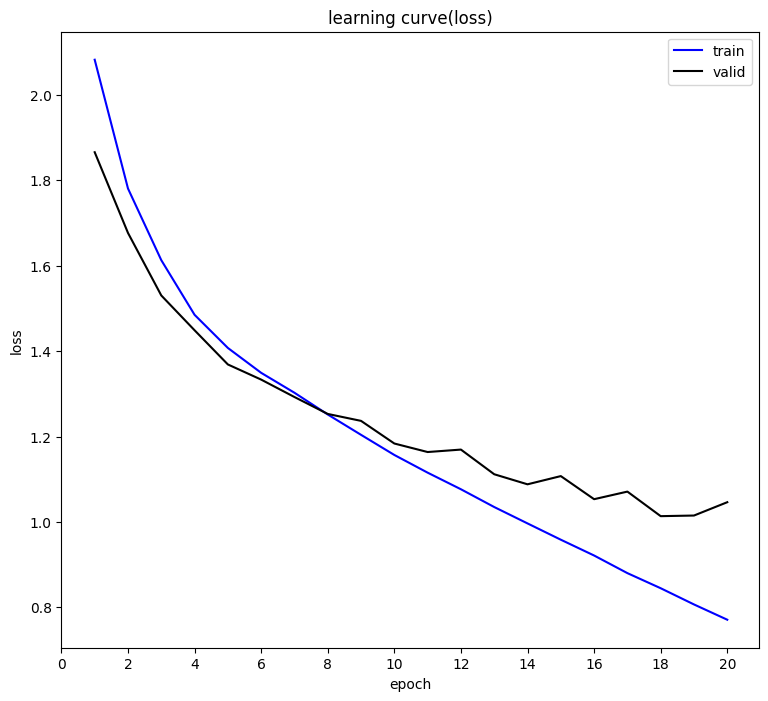

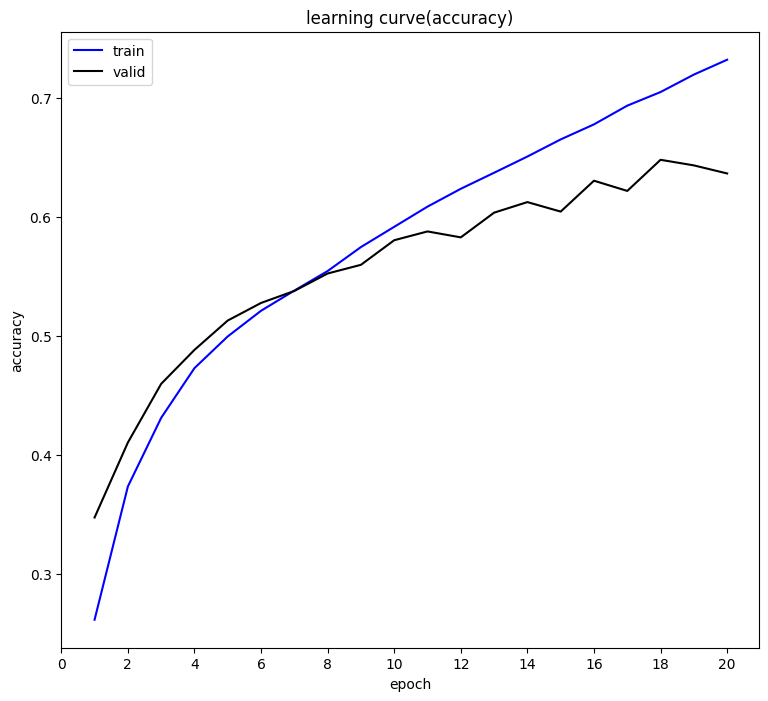

In [40]:
evaluate_history(history2)

n_size =  50


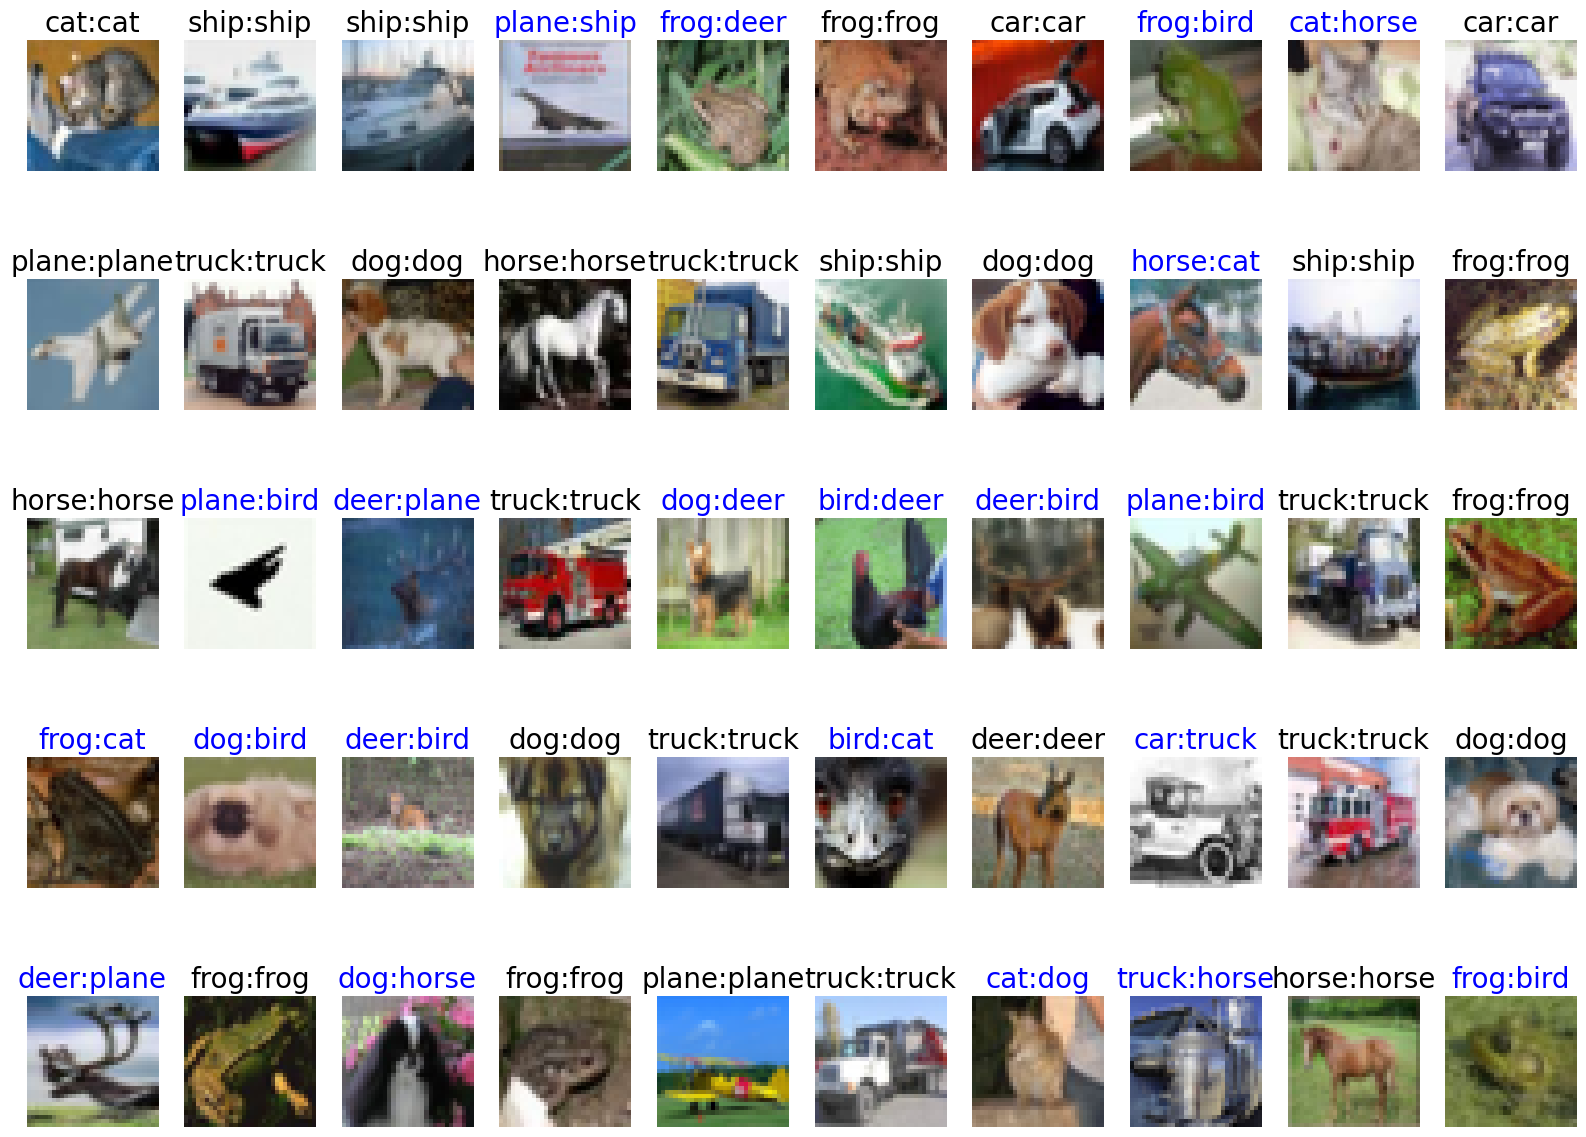

: 

In [ ]:
show_images_labels(test_loader2, classes, net, device)